In [17]:
import numpy as np
import pandas as pd

In [40]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
Y_train = train['label'].to_numpy()
#Y_test = test['label'].to_numpy()
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
#CONJUNTO TRAIN
train = train.drop(['label'], axis=1)
X_train = train.to_numpy()
mtrain = X_train.shape[0]
X_train = X_train.reshape((mtrain,28,28))
print("Y_train","\t", "   X_train")
print(Y_train.shape,"\t",  X_train.shape)

Y_train 	    X_train
(42000,) 	 (42000, 28, 28)


In [42]:
#CONJUNTO TEST
X_test = test.to_numpy()
mtest = X_test.shape[0]
X_test = X_test.reshape((mtest,28,28))
print("X_test", X_test.shape)

X_test (28000, 28, 28)


# ONE HOT ENCODING

In [43]:
y_train = np.zeros((10,mtrain))
_y = Y_train.reshape((1,mtrain))
for i in range(mtrain):
  y_train[:,i][_y[0,i]] = 1

x_train = X_train

In [44]:
print("x_train:",x_train.shape)
print("y_train:",y_train.shape)

x_train: (42000, 28, 28)
y_train: (10, 42000)


# NORMALIZACIÓN

In [45]:
x_train = x_train/255
x_test = X_test/255

In [46]:
#CONVIRTIENDO EL x_train A UNA IMAGEN 3D DE UN SOLO CANAL(SOLO EJECUTAR UNA VEZ)
print("Antes:", x_train.shape)
x_train = x_train[:,np.newaxis,...]
print("Despues:", x_train.shape)

#CONVIRTIENDO EL x_test A UNA IMAGEN 3D DE UN SOLO CANAL(SOLO EJECUTAR UNA VEZ)
print("Antes:",x_test.shape)
x_test = x_test[:,np.newaxis,...]
print("Despues:", x_test.shape)

Antes: (42000, 28, 28)
Despues: (42000, 1, 28, 28)
Antes: (28000, 28, 28)
Despues: (28000, 1, 28, 28)


# FUNCIONES NECESARIAS PARA EL FUNCIONAMIENTO DE LA RED

In [47]:
# FUNCIONES PARA LA CONVOLUCIÓN
# imgIn => (#ejemplos)x(#canales)x(ancho)x(altura)
# Filters => (#filtros)x(#canales)x(ancho)x(altura)
import math
def conv4D(imgIn, filters, padding, stride):
  m = imgIn.shape[0]
  filsize = filters.shape[2]
  numfil = filters.shape[0]
  n = int((imgIn.shape[2]+2*padding-filsize)/stride + 1)
  outputs = np.zeros((m,numfil,n,n))
  
  for i in range(m):
    img_i = imgIn[i]
    for h in range(0, stride*n, stride):
      for w in range(0, stride*n, stride):
        for c in range(numfil):
          aux = img_i[:,h:h+filsize,w:w+filsize]
          vec_aux = aux*filters[c]
          suma = np.sum(vec_aux)
          ha = int(h/stride)
          wa = int(w/stride)
          outputs[i,c,ha,wa] = suma
  return outputs

def maxpool(imgIn, filsize, stride, mode):
  m = imgIn.shape[0]
  n = int((imgIn.shape[2]-filsize)/stride + 1)
  numfil = imgIn.shape[1]
  outputs = np.zeros((m,numfil,n,n))
  img_max = np.zeros(imgIn.shape)

  for i in range(m):
    img_i = imgIn[i]
    for h in range(0, stride*n, stride):
      for w in range(0, stride*n, stride):
        for c in range(numfil):
          aux = img_i[c,h:h+filsize,w:w+filsize]
          ind = np.unravel_index(np.argmax(aux, axis=None), aux.shape)
          img_max[i,c,ind[0]+h,ind[1]+w] = 1
          ha = int(h/stride)
          wa = int(w/stride)
          if mode == "max":
            outputs[i,c,ha,wa] = np.max(aux)
          elif mode == "average":
            outputs[i,c,ha,wa] = np.mean(aux)
         
  return outputs, img_max

def dCn(img_max, dPn, filsize, stride):
  # img_max --> (m)x(#canales)x(ancho)x(altura)
  # img_max --> contiene las imagenes con 1 en donde están los max despues de aplicar el maxpool
  # dPn es la derivada con respecto a la salida de una capa maxpool
  m = img_max.shape[0]
  numfil = img_max.shape[1]
  n = int((img_max.shape[2]-filsize)/stride + 1)
  for i in range(m):
    img_i = img_max[i]
    delta = dPn[i]
    for h in range(0, stride*n, stride):
      for w in range(0, stride*n, stride):
        for c in range(numfil):
          aux = img_i[c,h:h+filsize,w:w+filsize]
          ind = np.unravel_index(np.argmax(aux, axis=None), aux.shape)
          ha = int(h/stride)
          wa = int(w/stride)
          img_max[i,c,ind[0]+h,ind[1]+w] = delta[c,ha,wa]
  return img_max

def dPn(dZn, filters):
  m, dZsize = dZn.shape[0], dZn.shape[-1]
  numfil, channels, fsize = filters.shape[0], filters.shape[1], filters.shape[-1]
  n_pad = int(dZsize/2)
  dZn_pad = padding4D(dZn, n_pad, n_pad)
  dZnpadsize = dZn_pad.shape[-1]
  n = (dZnpadsize-fsize)+1
  output = np.zeros((m,channels, n, n))

  filters_aux = change_filters(filters)
  
  for i in range(m):
    dZn_pad_i = dZn_pad[i]
    for h in range(0,n,1):
      for w in range(0,n,1):
        for c in range(channels):
          output[i,c,h,w] = np.sum(dZn_pad_i[:, h: h+fsize, w: w+fsize] * rotate3D(filters_aux[c]))
  return output

def change_filters(filters):
  numfil, channels, n_H, n_W = filters.shape
  output = np.zeros((channels, numfil, n_H, n_W))
  for i in range(channels):
    for j in range(numfil):
      output[i,j] = filters[j,i]
  return output

def flatten(imgIn):
  (m,n_C,n_H,n_W) = imgIn.shape
  x = imgIn.reshape((n_C*n_H*n_W,m))
  return x


def dKn(P_anterior, dZn, Kn):
  n = Kn.shape[-1]
  m = dZn.shape[0]
  l, z, x, y = Kn.shape
  dKni = np.zeros((m, l, z, x, y))
  #outputs = np.zeros(Kn.shape)
  filsize = dZn.shape[-1]
  for i in range(m): # por cada ejemplo de entrenamiento
    dZni = dZn[i] #16x8x8
    Pi = P_anterior[i] # 10x12x12
    for j in range(dZni.shape[0]): # por cada filtro
      dZnij = dZni[j] # 8x8
      c = Pi.shape[0]
      for k in range(0, c, 1):
        for h in range(0, n, 1):
          for w in range(0, n, 1):
            aux = Pi[k,h:h+filsize,w:w+filsize]
            vec_aux = dZnij*aux
            suma = np.sum(vec_aux)
            dKni[i,j,k,h,w] = suma
    dKn = np.mean(dKni, axis = 0)
  return dKn

#FUNCIONES DE ACTIVACIÓN Y DE PÉRDIDA
relu = (lambda x : np.maximum(x, 0),
        lambda x : (x > 0) * 1)
f_loss_logistic = (lambda y,a: -np.mean(y*np.log(a[-1])+(1-y)*np.log(1-a[-1])) , 
          lambda y,a: -(y/a - (1-y)/(1-a)))
f_sigmoid = (lambda z: 1/(1+np.exp(-z)), 
             lambda z: z*(1-z))

#FUNCIONES PARA LA RED NEURONAL TOTALMENTE CONECTADA
def init_parameters(L, struct):
  teta = []
  b = np.random.rand(L-1,1)*2-1

  for i in range(L-1):
    teta_aux = np.random.rand(struct[i+1],struct[i])*2-1
    teta.append(teta_aux)

  return teta, b

def forward(x_train, teta, b, f_act, L):
  out = []
  out.append(x_train)
  for i in range(L-1):
    if i == L-2:
      y_pred, y_prob = softmax(out, teta, b)
      out.append(y_prob)
    else:
      z = teta[i] @ out[-1] + b[i]
      a = f_act[0](z)
      out.append(a)

  return out, y_pred


def backward(y_train, out, f_loss, f_act, L, teta, b, lr):
  deltas = []
  for i in range(L-2, -1, -1):
    if i == L-2:
      #delta = out[-1]-y_train
      delta = f_loss[1](y_train, out[-1]) * f_act[1](out[-1])
      deltas.insert(0,delta)
    else:
      delta = (_teta.T @ delta)*f_act[1](out[i+1])
      #delta = (teta[i+1].T @ delta)*f_act[1](out[i+1])
      deltas.insert(0,delta)
    
    _teta = teta[i]
    # ACTUALIZACION DE PARÁMETROS 
    teta[i] = teta[i] - lr*(deltas[0] @ out[i].T)
    b[i] = b[i] - lr*np.mean(deltas[0])
  
  return deltas

# NEURONA SOFTMAX
def softmax(outputs, teta, b):
  z = teta[-1] @ outputs[-1] + b[-1]
  t = np.exp(z)
  suma = np.sum(t, axis = 0, keepdims = True)
  for i in range(t.shape[1]):
    t[:,i] = t[:,i]/suma[:,i]
  y_prob = t.astype(float)
  indice = np.argmax(t, axis = 0)
  for i in range(t.shape[1]):
    t[:,i] = 0
    t[:,i][indice[i]] = 1
  return t, y_prob

def rotate3D(filters):
  for i in range(filters.shape[0]):
    filters[i] = filters[i][::-1,::-1]
  return filters

def rotate4D(filters):
  for i in range(filters.shape[0]):
    filters[i] = filters[i][::-1,::-1,::-1]
  return filters

def padding3D(a,f,c):
  b = np.pad(a, ((0,0), (f,f), (c,c)), 'constant')
  return b

def padding4D(a,f,c):
  b = np.pad(a, ((0,0), (0,0), (f,f), (c,c)), 'constant')
  return b

# ESTRUCTURA DE LA RED NEURONAL CONVOLUCIONAL

<img src = "cnn-description.jpg">

# ENTRENAMIENTO DE LA RED

0.7929786027265462


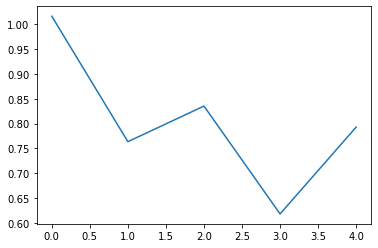

In [ ]:
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
m = 10000
imgIn = x_train[0:m]
B = np.random.rand(2,1)
K1 = np.random.rand(10,1,5,5)
K2 = np.random.rand(16,10,5,5)

struct = np.array([256,512,512,10])
L = struct.shape[0]
teta, b = init_parameters(L,struct)
lr = 0.0001
loss = []

for i in range(10):
  mini_batch_size = 512
  for j in range(mini_batch_size,m,mini_batch_size):
    x_train_mini = imgIn[j-mini_batch_size:j]
    #FORWARD 
    #CONVLAYER 1
    Z1 = conv4D(x_train_mini, K1, 0, 1) + float(B[0])
    C1 = relu[0](Z1)
    P1, P1_aux= maxpool(C1,2,2,'max')
    #CONVLAYER 2
    Z2 = conv4D(P1, K2, 0, 1) + float(B[1])
    C2 = relu[0](Z2)
    P2, P2_aux = maxpool(C2,2,2,'max')
    #FLATTEN LAYER
    f = flatten(P2)
    #FULLY CONNECTED
    outputs, y_pred = forward(f, teta, b, f_sigmoid, L)
    #LOSS FUNCTION
    e = f_loss_logistic[0](y_train[:,j-mini_batch_size:j],outputs)
    loss.append(e)

    #BACKWARD
    #FULLY CONNECTED
    deltas = backward(y_train[:,j-mini_batch_size:j], outputs, f_loss_logistic, f_sigmoid, L, teta, b, lr)
    #FLATTEN LAYER
    dP2 = (teta[0].T @ deltas[0]).reshape(P2.shape)
    #CONVLAYER 2
    dC2 = dCn(P2_aux, dP2, 2, 2)
    dZ2 = dC2 * relu[1](Z2)
    dK2 = dKn(P1, dZ2, K2)
    #Actualizacion de parámetros de la capa 2
    K2 = K2 - lr*dK2
    B[1] = B[1] - lr*np.sum(dZ2)
    #CONVLAYER 1
    dP1 = dPn(dZ2, K2)
    dC1 = dCn(P1_aux, dP1, 2, 2)
    dZ1 = dC1 * relu[1](Z1)
    dK1 = dKn(imgIn, dZ1, K1)
    #Actualizacion de paramétros de la capa 1
    K1 = K1 - lr*dK1
    B[0] = B[0] - lr*np.sum(dZ1)

    clear_output(wait = True)
    plt.show()
    plt.plot(range(len(loss)), loss)
    print(loss[-1])
    plt.show()
    time.sleep(0.1)

# PREDICCIÓN DEL MODELO

In [ ]:
#FORWARD PASS DEL MODELO
imgPred = x_test[0:1600]
Z1 = conv4D(imgPred, K1, 0, 1) + float(B[0])
C1 = relu[0](Z1)
P1, P1_aux= maxpool(C1,2,2,'max')
#CONVLAYER 2
Z2 = conv4D(P1, K2, 0, 1) + float(B[1])
C2 = relu[0](Z2)
P2, P2_aux = maxpool(C2,2,2,'max')
#FLATTEN LAYER
f = flatten(P2)
#FULLY CONNECTED
outputs, y_pred = forward(f, teta, b, f_sigmoid, L)

# PRECISIÓN DEL MODELO

In [ ]:
acc = 0
for i in range(mtest):
  if np.argmax(y_pred[:,i]) == np.argmax(y_test[:,i]):
    acc = acc + 1

print(acc)
print(acc/total)

# VISUALIZACIÓN DE LAS IMÁGENES

In [ ]:
plt.imshow(x_test[1][0])
plt.show()